This introduces another of the new features in the 2017.09 release of the RDKit: the `SubstructLibrary` - a class to make it straightforward to do substructure searches across sets of compounds.

In [33]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
print(rdBase.rdkitVersion)

2018.03.1.dev1


In [3]:
from rdkit.Chem import rdSubstructLibrary

To improve the efficiency of searches, the `SubstructLibary` allows you to provide RDKit Pattern fingerprints for the compounds in the library. These can (and should) be precalculated. Here's one way to do so:

Build our first `SubstructLibrary`. There are a number of ways of doing this, here we'll build one that expects that the molecules are provided as "trusted" SMILES (i.e. SMILES where the aromaticity and stereochemistry has been set by the RDKit). We'll add the SMILES (without actually converting them into molecule) and the fingerprints we calculated above

In [26]:
import pickle
mols = rdSubstructLibrary.CachedTrustedSmilesMolHolder()
fps = rdSubstructLibrary.PatternHolder()
with open('../data/chembl_50K.txt','r') as inf:
    ls = [x.split() for x in inf]
    ls.pop(0)
    with open('../data/chembl_50K.fps.pkl','rb') as pklf:
        for l in ls:
            smi = l[1]
            mols.AddSmiles(smi)           
            fp = pickle.load(pklf)
            fps.AddFingerprint(fp)
library = rdSubstructLibrary.SubstructLibrary(mols,fps)

In [27]:
indices = library.GetMatches(Chem.MolFromSmiles('c1ccncn1'))
print(len(indices))

1000


In [28]:
indices = library.GetMatches(Chem.MolFromSmiles('c1ccncn1'),maxResults=10000)
print(len(indices))

5622


In [29]:
indices = library.GetMatches(Chem.MolFromSmiles('c1ncncn1'))
print(len(indices))

246


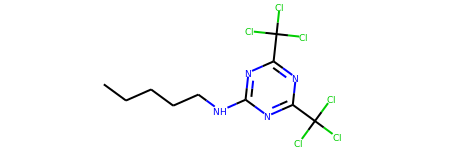

In [32]:
library.GetMol(indices[0])

Let's look at how long that takes:

In [35]:
%timeit library.GetMatches(Chem.MolFromSmiles('c1ncncn1'))

10.7 ms ± 582 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Not bad at all, but let's look at a larger dataset.

Here's the pre-processing work for 500K molecules randomly selected from ChEMBL:

The same code to read them in:

In [36]:
import pickle
mols = rdSubstructLibrary.CachedTrustedSmilesMolHolder()
fps = rdSubstructLibrary.PatternHolder()
with open('../data/chembl_500K.txt','r') as inf:
    ls = [x.split() for x in inf]
    ls.pop(0)
    with open('../data/chembl_500K.fps.pkl','rb') as pklf:
        for l in ls:
            smi = l[1]
            try:
                fp = pickle.load(pklf)
            except EOFError:
                break
            mols.AddSmiles(smi)           
            fps.AddFingerprint(fp)
library = rdSubstructLibrary.SubstructLibrary(mols,fps)

In [37]:
indices = library.GetMatches(Chem.MolFromSmiles('c1ncnc(O)n1'))
print(len(indices))

373


In [38]:
%timeit library.GetMatches(Chem.MolFromSmiles('c1ncnc(O)n1'))

53.4 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
len(library.GetMatches(Chem.MolFromSmiles('c1ccccc1C(=O)c1ccccc1'),maxResults=10000))

3520

In [42]:
%timeit library.GetMatches(Chem.MolFromSmiles('c1ccccc1C(=O)c1ccccc1'),maxResults=10000)

832 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
